In [8]:
import torch
import galsim
import batsim
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.signal import convolve2d

In [2]:
gsparams = galsim.GSParams(maximum_fft_size=2e4)
galaxy = galsim.Sersic(n=5.0, half_light_radius=1.0, flux=40, gsparams=gsparams)
psf = galsim.Moffat(beta=3.5, fwhm=0.8)
conv = galsim.Convolve([galaxy, psf])

nyq = galaxy.nyquist_scale
nn = galaxy.getGoodImageSize(nyq)
print(nn)

galaxy_im = galaxy.drawImage(nx=nn, ny=nn, scale=nyq, method='no_pixel').array
psf_im = psf.drawImage(nx=nn, ny=nn, scale=nyq, method='no_pixel').array

gs_conv = conv.shift(-0.5*nyq, -0.5*nyq).drawImage(nx=nn, ny=nn, scale=nyq, method='no_pixel').array

8192


In [3]:
8192**2

67108864

In [4]:
# Check GPU and CPU are available
print('CUDA?:', torch.cuda.is_available())
print('# GPUs:', torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

# Set GPU
GPU = torch.cuda.device(0)

CUDA?: True
# GPUs: 4
NVIDIA A100-SXM4-80GB


Scipy time: 2.370558023452759


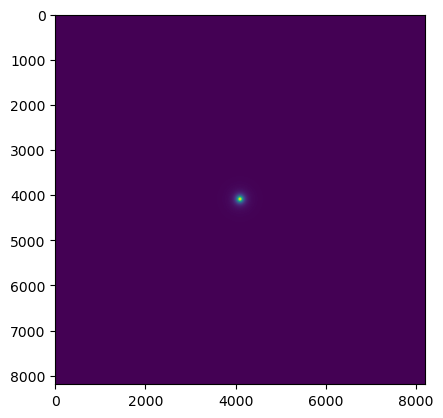

In [5]:
#Benchmark with Scipy
start = time()

# Forward transform
im1_fft = fft2(fftshift(galaxy_im))
im2_fft = fft2(fftshift(psf_im))

# convolve images 
conv_im_fft = im1_fft * im2_fft

# Backward transform
conv_im_scipy = ifftshift(ifft2(conv_im_fft))

scipy_time = time()-start
print('Scipy time:', scipy_time)

plt.imshow(conv_im_scipy.real)

PyTorch time: 0.3529846668243408
PyTorch is 6.716 times faster


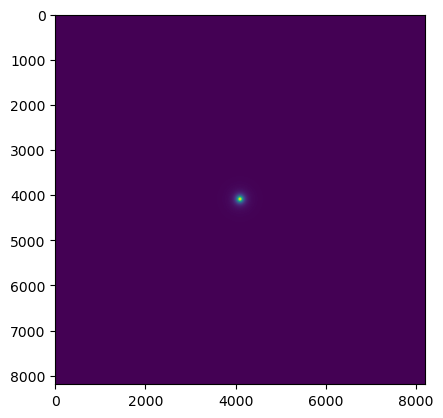

In [7]:
# Now try using pytorch
start = time()

# Pad the images for FFT
pad_width = nn//100
gal_im_pad = np.pad(galaxy_im, pad_width)
psf_im_pad = np.pad(psf_im, pad_width)

# send data to GPU
torch_im1 = torch.tensor(fftshift(gal_im_pad)).to('cuda')
torch_im2 = torch.tensor(fftshift(psf_im_pad)).to('cuda')

# Forward transform
im1_fft = torch.fft.rfft2(torch_im1)
im2_fft = torch.fft.rfft2(torch_im2)

# Convolve
convolved = im1_fft * im2_fft

# Backward transform
conv_im_torch = torch.fft.irfft2(convolved)
conv_im_torch = ifftshift(conv_im_torch.detach().cpu())

torch_time = time()-start
print('PyTorch time:', torch_time)
print('PyTorch is %1.3f times faster'%(scipy_time/torch_time))
#assert conv_im_torch.all() == conv_im_scipy.all()

# Crop padding from result 
conv_im_torch = conv_im_torch[pad_width:-pad_width,pad_width:-pad_width]
#torch.empty_cache()
torch.cuda.empty_cache()
plt.imshow(conv_im_torch)

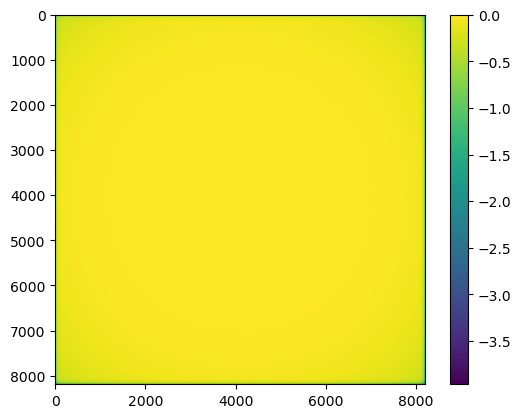

In [73]:
plt.imshow((conv_im_torch - gs_conv)/conv_im_torch)
plt.colorbar()